In [1]:
# Imports and Setup

import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d as smooth

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 15}

plt.rc('font', **font)

from forward_multiple_GHG import fair_scm as FAIR_model

In [2]:
#import emissions and RF data from file

datafile = 'RCP3PD'

emms_file = './RCPs/' + datafile + '_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0

forc_file = './RCPs/'+datafile+'_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

In [3]:
#import piers data for total anthro RF

rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))

#import median data anthro forcing from richard
rf_comps_median = np.loadtxt("Annualforcings_Mar2014_GHGrevised.txt", skiprows=4)

#sum components of file to make total...
rf_anthro_median = rf_comps_median[:,1] + rf_comps_median[:,2] + rf_comps_median[:,3] + rf_comps_median[:,4] +  rf_comps_median[:,6] + rf_comps_median[:,7] + rf_comps_median[:,8] + rf_comps_median[:,9] + rf_comps_median[:,10]  
rf_other_median = rf_comps_median[:,13] - rf_comps_median[:,14]
rf_total_median = rf_comps_median[:,13]

y_0 = int(rf_comps_median[0,0])
time = rf_comps_median[:,0] 

In [4]:
def co2_forcing_2(T_in, 
                  other_rf = None, 
                  other_rf_in = False, 
                  tcrecs = np.array([1.6,2.75]), 
                  tstep = 1.0,
                  F_2x = 3.74,
                  d=np.array([239.0,4.1]),
                  q=np.array([0.33,0.41]),
                  in_state = np.array([[0.0,0.0],[0.0,0.0]])):

   # --- PARAMETERS ---
    # other_rf = radiative forcing profile which is in addition to the anthropogenic forcings
    # other_rf_in = boolean, allows user to turn on or off funcitonality for other rf profile inclusion
    # tcrecs = inputted TCR and ECS values, default = [1.6,2.75]
    # tstep = time step interval, default = 1.0 yrs, (never tested for others)
    # F_2x = forcing response to doubling CO2 concentration (W/m^2)
    # d = time constants for temperature boxes
    # q = parameters which relate to TCR and ECS values (Millar et al. 2017)
    # in_state = inputted state of vectors, ie. [T_comp], [co2_rf_pre, other_rf_pre]. Default = zeros.
   # ---  ---  ---  ---
   
   #NOTE: Myles parameters set:
    # tcrecs often set to [1.8,3.0], not always though, be aware
    # d = np.array([4.1,249.0])
    # q = np.array([0.631, 0.429])
    
   # --- INITIALIZE ARRAYS ---
    co2_rf = np.zeros(T_in.size)
    T_comp = np.zeros((T_in.size,2))
    # If other rf profile not inputted set other_rf to a zero vector
    if other_rf_in == False:
        other_rf = np.zeros(T_in.size)
    
   # --- CALCULATE Q ARRAY ---
    # If TCR and ECS are supplied, overwrite the q array
    k = 1.0 - (d/70.0)*(1.0 - np.exp(-70.0/d))
    if type(tcrecs) in [np.ndarray,list]:
        q =  (1.0 / F_2x) * (1.0/(k[0]-k[1])) \
            * np.array([tcrecs[0]-k[1]*tcrecs[1],k[0]*tcrecs[1]-tcrecs[0]])
    
   ### --- FIRST TIMESTEP ---
    # Set the initial values of key parameters as the in_state values, default = zeros.
    T_comp_pre = in_state[0]
    co2_rf_pre = in_state[1,0]
    other_rf_pre = in_state[1,1]
    
    # Calculate the temperature contribution to the total from each box, after it has decayed from the previous timestep
    T_d = T_comp_pre[:]*(np.exp((-tstep)/d[:]))

    # Estimate the co2 radiative forcing required to give that temperature change between last timestep and this one
    co2_rf[0] = (T_in[0] - np.sum(T_d) - other_rf[0]*np.sum(q*(1-np.exp((-tstep)/d)))) / (np.sum(q*(1-np.exp((-tstep)/d)))) 
    
    # Calcualate the contribution to the temperature boxes from the changed radiative forcing in this timestep, 
        #compared to the previous one
    T_f = q[:]*(co2_rf[0]+other_rf[0]) * (1-np.exp((-tstep)/d[:]))
        
    # Total temperature of each box is the sum of the decayed temperature 
        #from previous step and the forced temp from this step
    T_comp[0,:] = T_d + T_f
   # ---------------------
    
   ### --- REST OF RUN ---
    for x in range(1,T_in.size):
        # Calcualate temperature contribution from each box, assuming it decays since last timestep
        T_d = T_comp[x-1,:]*(np.exp((-tstep)/d[:]))
        
        # Calculate the required radiative forcing to produce observved temperature at this timestep, 
            #given the sum of the decayed temperatures in each box, from previous timestep
        co2_rf[x] = (T_in[x] - np.sum(T_d) - other_rf[x]*np.sum(q*(1-np.exp((-tstep)/d)))) / (np.sum(q*(1-np.exp((-tstep)/d)))) 
        
        # Calculate the contribution to the temperature of each box from the RF change from the previous step
        T_f = q[:]*(co2_rf[x]+other_rf[x]) * (1-np.exp((-tstep)/d[:]))
        
        # Total temperature contribution of each box is sum of decayed temperature from previous step 
            #and forcing temperature from this step
        T_comp[x,:] = T_d + T_f
   # -------------------
        
    return co2_rf

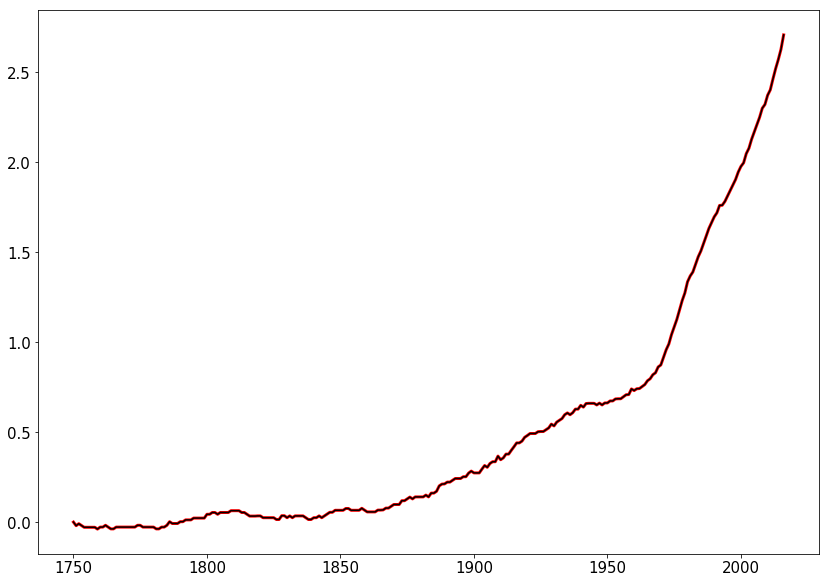

In [5]:
out = FAIR_model(other_rf = rf_anthro_median, MAGICC_model = True)
temp = out['temperature']
RF_out = co2_forcing_2(temp)

plt.plot(time, RF_out, color = 'red', linewidth = 3)
plt.plot(time, rf_anthro_median, color = 'black')

In [6]:
# Define a function which given a radaitive forcing can calculate the equivalent CO2 concentration
def co2_conc_total(RF_in, 
                   RF_ext = None, 
                   RF_ext_in = False, 
                   a = 5.396, 
                   Cpreind = 278.):
    
   # --- PARAMETERS ---
    # Cpreind = preindustrial CO2 concentration in ppmv
    # a = logarithmic forcing efficacy in W/m-2/alog(2). Default = 5.396 W/m^2
    # RF_ext = external radaitive forcing profile which contributes but shouldn't add to the equivalent CO2 concentrations
    # RE_ext_in = boolean, allows user to include or not include the contribution to RF of other (non-anthropogenic) sources
   #---  ----  ---  ---
    
   # Initializing arrays
    # Create array to hold concentration values
    C = np.zeros(RF_in.size)
    
    # Check inputs are of the same size if external forcing data is also provided
    if RF_ext_in == True:
        if RF_in.size != RF_ext.size:
            print 'The inputs RF_in and RF_ext are not of the same size!'
    elif RF_ext_in == False:
        RF_ext = np.zeros(RF_in.size)
    
   # Compute required co2 concentration to produce inputted logarithmic forcing
    for i in range(0, RF_in.size):
        C[i]=np.exp((RF_in[i]-RF_ext[i])/a)*Cpreind
    
    return C

In [7]:
C_out = co2_conc_total(rf_anthro_median)

In [8]:
import numpy as np
from scipy.optimize import root
import scipy.ndimage.filters as filters1

def iirf100_interp_funct(alpha,a,tau,targ_iirf100):
    iirf100_arr = alpha*(np.sum(a*tau*(1.0 - np.exp(-100.0/(tau*alpha)))))
    return iirf100_arr   -  targ_iirf100

# Define function which does inversion of carbon dioxide concentration to emissions of carbon
def annual_emissions_calc2(co2_conc, T_input, 
                           t_const = np.array([1000000,381.330,34.7850,4.12370]), 
                           pool_splits = np.array([0.21787,0.22896,0.28454,0.26863]),
                           GtC_2_ppmv = 0.471,
                           r0=32.40,
                           rC=0.019,
                           rT=4.165,
                           iirf100_max = 97.,
                           Cpreind = 278,
                           tstep = 1.0,
                           year_smoothing = 0,
                           in_state=[[0.0,0.0,0.0,0.0],[0.0,0.0],0.0]):
    
   # PARAMETERS #
    # co2_conc = inputted co2 forcing equivalent concentration profile
    # T_input = inputted temperature profile for given concentration profile
    # t_const = time constants for the different carbon pools
    # pool_splits = how a unit mass of carbon is split between the pools
    # r0 = 100-year integrated airborne fraction (iIRF100) in the initial equilibrium climate for an infinintesimal pulse
    # rC = sensitivity of iIRF100 to cumulative land-ocean carbon uptake, in years/GtC
    # rT = temperature sensitivity of iIRF100 in years/K
    # iirf100_max = maximum value of the iIRF100 we can calculate (saturates at this value if found to be above)
    # Cpreind = pre-industrial CO2 concentration
    # tstep = timestep between interations of code. Default = 1 yr, never tried for other
    # in_state = input state of the different vectors being calcualted
    
   #NOTE: Myles parameters set:
    #t_const = np.array([1.e8,381.330,34.7850,4.12370])
    #pool_splits = np.array([0.21787,0.22896,0.28454,0.26863])
    #r0 = 35.
    #rC = 0.02
    #rT = 4.5
    #iirf100_max = 95.
     
   #initialize the carbon pools, emissions, accumulated carbon and iIRF100 vectors. 
    #Give an intial guess of alpha for root function to work from.
    C_comp = np.zeros((co2_conc.size, 4))
    E = np.zeros(co2_conc.size)
    C_acc = np.zeros(co2_conc.size)
    iirf100 = np.zeros(co2_conc.size)
    alph_t = 0.16
    
   ###---------FIRST TIMESTEP----------
    #set the initial values of key parameters as the in_state values, default = zeros.
    C_comp_pre = in_state[0]
    C_pre = np.sum(C_comp_pre) + Cpreind
    T_j_pre = in_state[1]
    C_acc_pre = in_state[2]

    # Calculate the parametrised iIRF100 and check if it is over the maximum allowed value
    iirf100[0] = r0 + rC*C_acc[0] + rT*T_input[0]
    if iirf100[0] >= iirf100_max:
        iirf100[0] = iirf100_max
    
    #find the value of alpha
    alph_t = (root(iirf100_interp_funct,alph_t,args=(pool_splits,t_const,iirf100[0])))['x']
    
    #compute the carbon in each pool
    C_comp[0,:] = C_comp_pre[:]*np.exp((-tstep)/(alph_t*t_const[:]))
    
    p1 = 0.
    p2 = 0.
    for j in range(0,4):
        p1 = p1 + C_comp[0,j]
        p2 = p2 + pool_splits[j]*t_const[j]*(1-np.exp((-tstep)/(alph_t*t_const[j])))
    #compute the emissions required to give change in CO2 concentration
    E[0] = (co2_conc[0] - p1 - C_pre) / (0.5*alph_t*p2*GtC_2_ppmv)
    
    #recompute the distribution of carbon in each pool for better estimation of emissions in next timestep
    C_comp[0,:] = C_comp[0,:] + 0.5*alph_t*pool_splits[:]*t_const[:]*E[0]*GtC_2_ppmv*(1-np.exp((-tstep)/(alph_t*t_const[:])))
    
    #calculate the accumulated carbon in the land and oceans
    C_acc[0] =  C_acc_pre + E[0]*tstep - ((co2_conc[0]-C_pre)/GtC_2_ppmv)
    
   ###----------REST OF RUN-------------
    
    for i in range(1, co2_conc.size):
        #estimate the value of iIRF100, given the temperature and accumulated carbon in previous timestep
        iirf100[i] = r0 + rC*C_acc[i-1] + rT*T_input[i-1]
        if iirf100[i] > iirf100_max:
            iirf100[i] = iirf100_max
        
        #calculate the value of alpha using scipys root finder
        alph_t = (root(iirf100_interp_funct,alph_t,args=(pool_splits,t_const,iirf100[i])))['x']
        
        #compute the distribution of carbon between the pools
        C_comp[i,:] = C_comp[i-1,:]*np.exp((-tstep)/(alph_t*t_const[:]))
        
        p1 = 0.
        p2 = 0.
        for j in range(0,4):
            p1 = p1 + C_comp[i,j]
            p2 = p2 + pool_splits[j]*t_const[j]*(1-np.exp((-tstep)/(alph_t*t_const[j])))
        #calculate the emissions required in this year to cause change in CO2 concentration
        E[i] = (co2_conc[i] - p1 - Cpreind) / (alph_t*p2*GtC_2_ppmv)
        
        #recalculate the distribution of carbon in each pool for better estimation in next timestep
        C_comp[i,:] = C_comp[i,:] + \
            alph_t*pool_splits[:]*t_const[:]*E[i]*GtC_2_ppmv*(1-np.exp((-tstep)/(alph_t*t_const[:])))
        
        #calculate the accumulated carbon in the land and sea
        C_acc[i] =  C_acc[i-1] + E[i]*tstep - ((co2_conc[i]-co2_conc[i-1])/GtC_2_ppmv)
        
   ###----------------------------------
   
    # We apply a gaussian filter to smooth the resulting curve 
    E_smooth = filters1.gaussian_filter1d(E, year_smoothing)
    
    return E, E_smooth

723.547954271


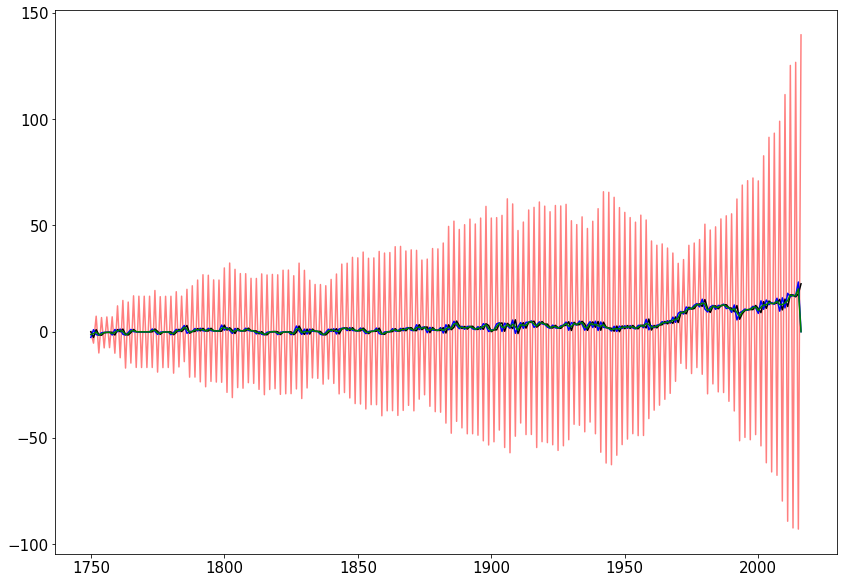

In [9]:
from fair_inverse_model import annual_emissions_calc2 as conc_to_emissions

ems_old_out = conc_to_emissions(C_out, temp, year_smoothing = 0)
ems_old_2ts = np.zeros(ems_old_out.size)
for i in range(0,ems_old_out.size-1):
    ems_old_2ts[i] = (ems_old_out[i] + ems_old_out[i+1])/2

ems_out, ems_out_smooth = annual_emissions_calc2(C_out, temp, year_smoothing = 5)
ems_2ts = np.zeros(ems_out.size)
for i in range(0,ems_out.size-1):
    ems_2ts[i] = (ems_out[i] + ems_out[i+1])/2

plt.plot(time, ems_old_out, color = 'red', alpha = 0.5)
plt.plot(time, ems_out, color = 'black')
#plt.plot(time, smooth(ems_out,5))
#plt.plot(time, smooth(ems_old_out,5))
plt.plot(time, ems_old_2ts, color = 'blue')
plt.plot(time, ems_2ts, color = 'green')

cum_sum_ems = np.cumsum(ems_out[1870-y_0:])
print cum_sum_ems[2011-1870]

Cumulative CO2 emissions 1870-2011 inclusive: 521.361796659 GtC (FAIR standard params)
524.809980602 GtC (FAIR standard params, other)


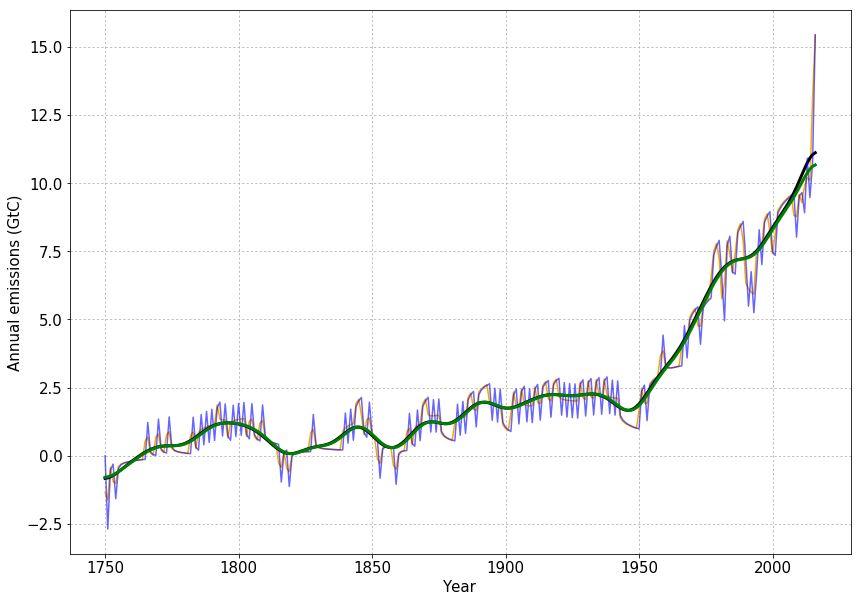

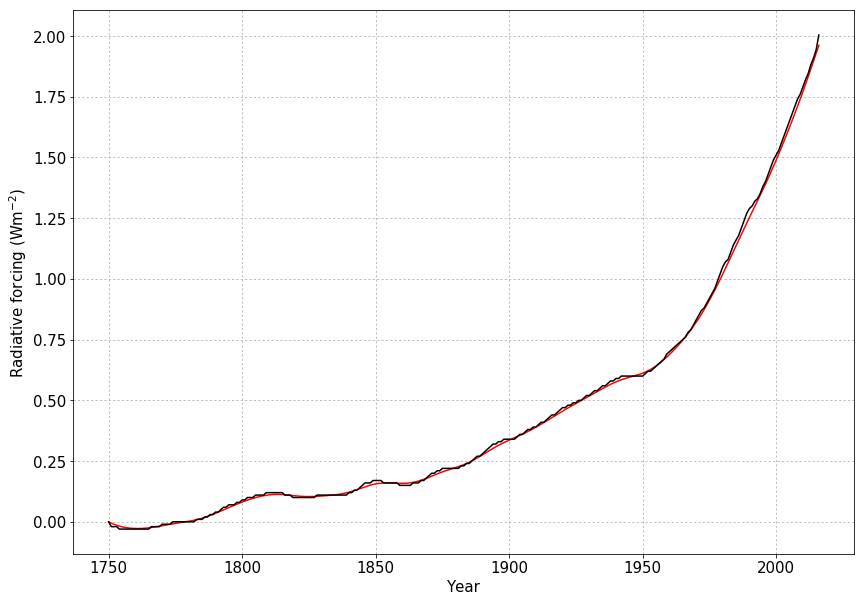

In [10]:
out2 = FAIR_model(other_rf = rf_comps_median[:,1], MAGICC_model = True)
temp2 = out2['temperature']
C_out2 = co2_conc_total(rf_comps_median[:,1])
ems_out2, ems_out_smooth2 = annual_emissions_calc2(C_out2, temp2, year_smoothing = 5)
cum_sum_co2_ems = np.cumsum(ems_out2[1870-y_0:])
print 'Cumulative CO2 emissions 1870-2011 inclusive:', cum_sum_co2_ems[2011-1870], 'GtC (FAIR standard params)'

ems_2ts2 = np.zeros(ems_out2.size)
for i in range(0,ems_old_out.size-1):
    ems_2ts2[i] = (ems_out2[i] + ems_out2[i+1])/2
ems_2ts2[-1] = ems_out2[-1]
print np.cumsum(ems_2ts2[1870-1750:])[2011-1870], 'GtC (FAIR standard params, other)'

plt.plot(time, ems_2ts2, color = 'orange')
plt.plot(time, smooth(ems_2ts2,5), color = 'black', linewidth = 3)

plt.plot(time, ems_out2, color = 'blue', alpha = 0.6)
plt.plot(time, ems_out_smooth2, color = 'green', linewidth = 3)
plt.grid(True, linestyle = ':')
plt.xlabel('Year')
plt.ylabel('Annual emissions (GtC)')

out_test = FAIR_model(emissions = ems_out_smooth2, MAGICC_model = True)
plt.figure()
plt.plot(time, out_test['forcing']['total'], color = 'red')
plt.plot(time, rf_comps_median[:,1], color = 'black')
plt.grid(True, linestyle = ':')
plt.xlabel('Year')
plt.ylabel('Radiative forcing (Wm$^{-2}$)')